# Explore MEL data with Spark
The purpose of this notebook is to validate the labelling of the mel spectrogram observations. Apache Spark is used as it is more performant when working with large files.

### Initialise Spark

In [1]:
import findspark
findspark.init('/Volumes/Thorshammer/Applications/spark')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Jupyter").getOrCreate()

spark.version

u'2.1.0'

In [5]:
sample_rate = 16000
sample_length = 4
stride = 0.01
# This following represent the first postive class observation in the data
positive_classes = {
    '161225-001' : 9541250,
    '161225-002' : 713600,
    '161225-003' : 813800,
    '161225-004' : 808700,
    '161225-005' : 686400
}

file_sufix = '.wav-mel.csv'
label_file_sufix = '-mel-labels.csv'
mel_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/'

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import librosa
import librosa.display
import os

def calc_mel_observation_index(raw_sample_number):
    observation_index = int(raw_sample_number / (sample_rate * stride))
    return observation_index

def plot_mel(data, hop_length):
    librosa.display.specshow(data, x_axis='time', sr=sample_rate, y_axis='mel', hop_length=hop_length)

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    plt.show()

import numpy as np
# for key in positive_classes:
def load_mel_data_rdd(filename):
    '''
    Load mel data from disk. Data is an array of mel 2d matrices.
    We need to iterate the array and reshape each matrix.
    Each matrix has dimensions 40 x 401 (there are 40 mel channels for a 4 sec sample).
    '''
    print('Loading mel data: %s'%filename)

    raw_lines_rdd = spark \
        .sparkContext \
        .textFile(filename) \
        .map(lambda line: line.split(',')) \
        .map(lambda v: map(float,v)) \
        .map(lambda v: np.asarray(v).reshape((40,401))) \
        .zipWithIndex() \
        .map(lambda (x,y): (y,x))

    return raw_lines_rdd

def load_mel_labels_rdd(filename):
    print('Loading mel data labels: %s'%filename)
    
    raw_lines_rdd = spark \
        .sparkContext \
        .textFile(filename) \
        .map(lambda line: int(line)) \
        .zipWithIndex() \
        .map(lambda (x,y): (y,x))
        
    return raw_lines_rdd

def get_mel_for_sample_index(rdd, sample_index) :
    return rdd.filter(lambda (x,y): x == calc_mel_observation_index(sample_index)).take(1)[0][1]

def get_mel_for_observation_index(rdd, observation_index) :
    return rdd.filter(lambda (x,y): x == observation_index).take(1)[0][1]

def get_mel_label_for_index(rdd, observation_index):
    return rdd.filter(lambda (x,y): x == observation_index).take(1)[0]

# Look at the mel spectrograph observations for the positive class
Validate that the labeling is correct by visual inspection.

Loading mel data labels: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-001-mel-labels.csv
Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-001.wav-mel.csv


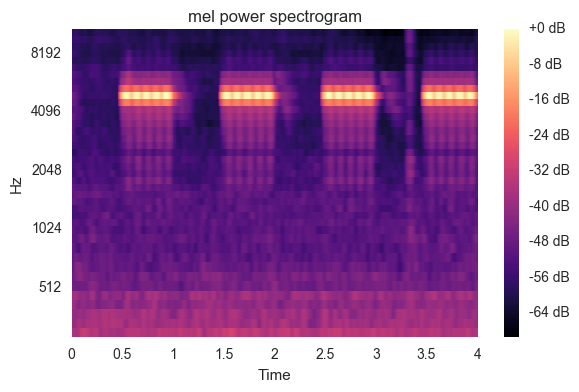

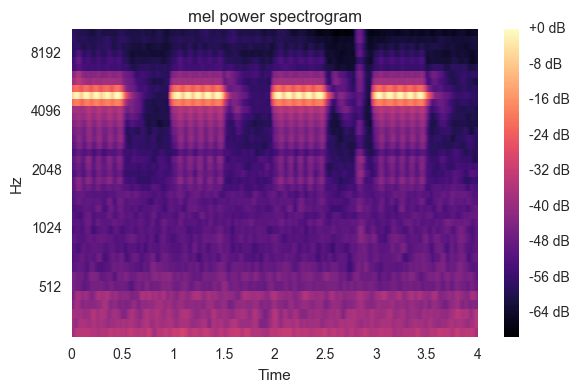

Loading mel data labels: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-002-mel-labels.csv
Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-002.wav-mel.csv


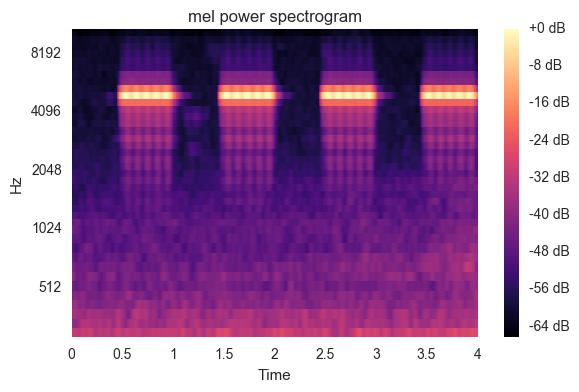

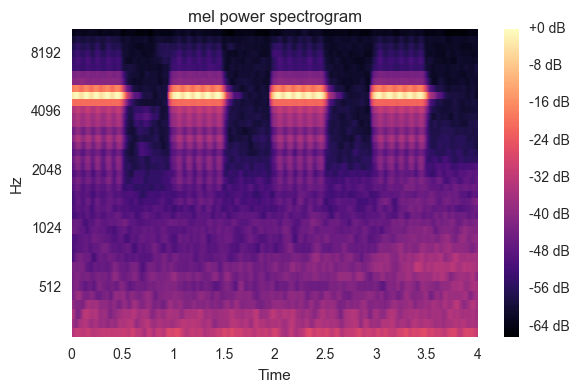

Loading mel data labels: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-003-mel-labels.csv
Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-003.wav-mel.csv


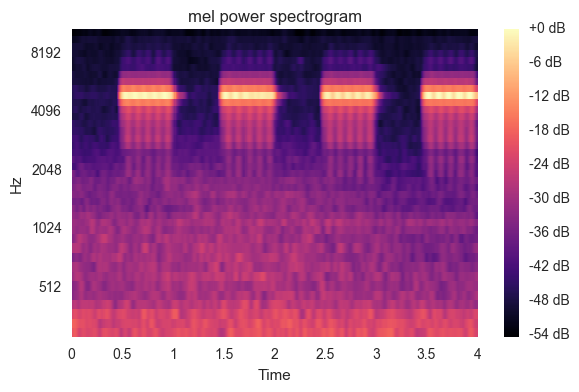

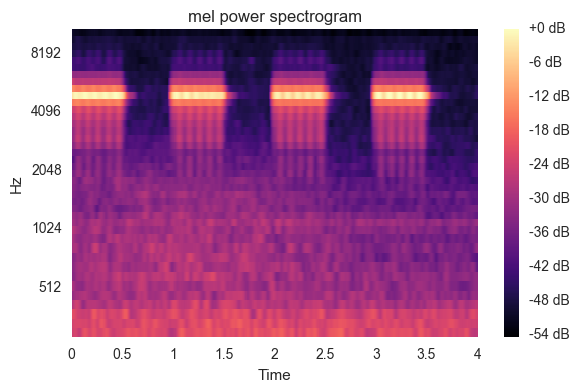

Loading mel data labels: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-004-mel-labels.csv
Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-004.wav-mel.csv


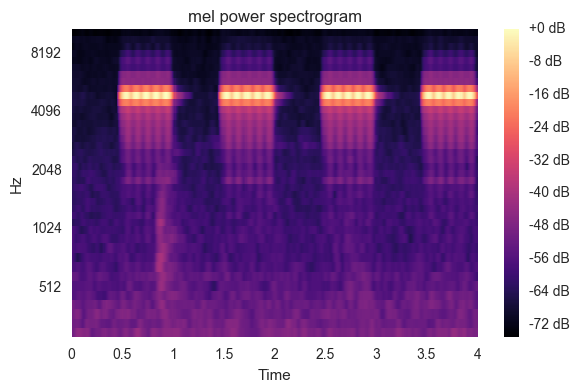

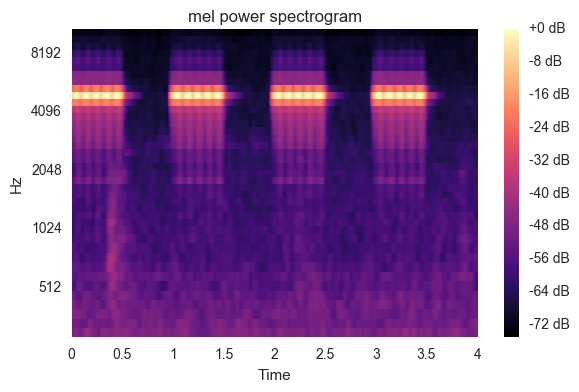

Loading mel data labels: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-005-mel-labels.csv
Loading mel data: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-005.wav-mel.csv


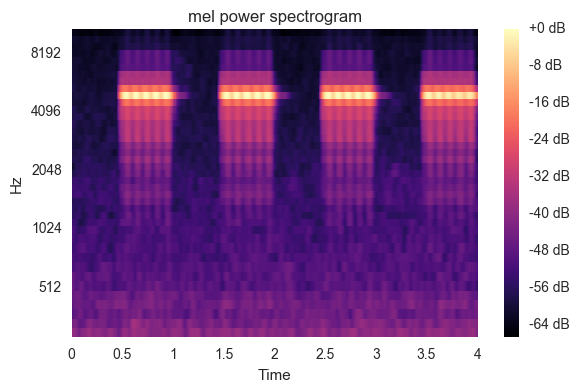

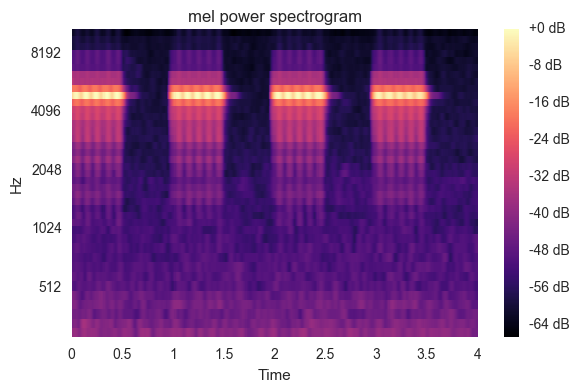

In [87]:
def plot_target_mel_boundary_for_filekey(key):
    """
    This function plots the mel spectrograms of the smallest and hightest index for positive target class labels.
    """
    
    mel_label_filename = os.path.join(mel_directory,key+label_file_sufix)
    mel_data_filename = os.path.join(mel_directory,key+file_sufix)

    mel_data_labels = load_mel_labels_rdd(mel_label_filename)
    mel_data = load_mel_data_rdd(mel_data_filename)

    positive_observations = mel_data.join(mel_data_labels).filter(lambda (idx,(x,y)): y == 1).sortByKey().collect()
    
    plot_mel(positive_observations[0][1][0],160)
    plot_mel(positive_observations[-1][1][0],160)
    
for key in sorted(positive_classes.keys()):
    plot_target_mel_boundary_for_filekey(key)

Based on the above plots the labeling seems to be correct.